# Correlation between fuel prices and freight transport

Project group 9

Thijn Schoonderbeek - 6090133

Jim van Erp - 5083540

Fos van der Meer - 4866436

Github: https://github.com/fosva/TIL6010-LabAssignments

## Introduction

Gas prices have been a highly controversial topic since the Covid-19 crisis of 2020 and the start of the Russia-Ukraine war in Februari 2022 as gas is the main fuel for the transportation sector. The costs of the transportation sector can be split in fixed costs and variable costs, where fuel prices are the most important part of the variable costs. It is therefore interesting to see the correlation between the price of gas and the use of various modes of transportation. Trains, ships and trucks are the main modes for the transportation of goods as their efficiency over long distances with high loads is relatively low. 

### Sub-questions

To answer our main research question and to support statements made in the introduction, a few sub questions have been created.

1. How have the prices of fuels developed over the years?
2. To what extent does the ratio of truck to rail transport change?
3. Is there a correlation between fuel prices and transport mode popularity?


## 1. Datasets

The datasets we will be using have the following structure, the names are those assigned by us:

| name | types of values | start time | end time | frequency | link |
| --- | --- | --- | --- | --- | --- |
| fuel | prices of gasoline, diesel and LPG | 2006 | 2023 | daily | https://data.overheid.nl/dataset/532-pompprijzen-motorbrandstoffen--brandstofsoort--per-dag#panel-description |
| old_fuel | prices of many types of fuel | 1960 | 2009 | yearly/quarterly | https://opendata.cbs.nl/statline/#/CBS/nl/dataset/7521/table?ts=1699484661211 |
| rail | different (inter)national rail transport statistics | 1986 | 2022 | yearly/quarterly | https://data.overheid.nl/dataset/1184-spoorvervoer--ladinggewicht--ladingtonkilometer--treinkilometers#panel-resources |
| road | different (inter)national road transport statistics | 1997 | 2022 | yearly | https://data.overheid.nl/dataset/1186-wegvervoer--kerncijfers#panel-resources |

Where start- and end times are those useful to us. The datasets that have quarterly data, only have it from relatively recent periods, not the given start time. Based on the fact that the `road` dataset has a yearly frequency, we decide to consider only yearly data. To bridge the gap that occurs in the `fuel` dataset, we have added an `old_fuel` dataset.

We will compare the given data from 1997 to 2022, on yearly basis.

## 2. Analysis 

### 2.1 Fuel prices

The fuel prices we will be looking at come from two different sources:

1. `fuel`: Daily recorded fuel prices since 2006:
    
    https://data.overheid.nl/dataset/532-pompprijzen-motorbrandstoffen--brandstofsoort--per-dag#panel-description

2. `old_fuel`: Yearly average recommendation fuel prices from 1990 until 2009:
    
    https://opendata.cbs.nl/statline/#/CBS/nl/dataset/7521/table?ts=1699483475736

We will combine these to extend the time range.

    Perioden  Diesel
25      2005  1.0240
26      2006  1.0872
27      2007  1.0980
28      2008  1.2865
29      2009  0.9990
            Diesel
Perioden          
2006      1.043211
2007      1.059721
2008      1.241314
2009      1.012929
2010      1.170838


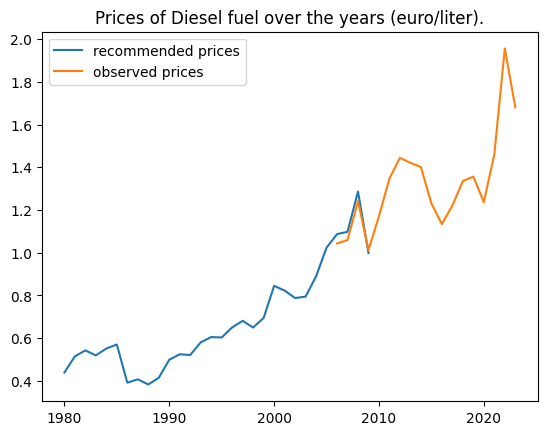

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#fuel dataset
#only take Diesel prices, Perioden (periods) are formatted as "2006 zondag 1 januari",
#prices are strings formatted with decimal comma
#ignore last row  about authorship.
fuel = pd.read_csv("data/fuel.csv", sep=";")[["Perioden", "Diesel"]][:-1]

# Replace prices commas with periods & convert to floating point
fuel["Diesel"] = fuel["Diesel"].map(lambda x: float(x.replace(',', '.')))

#Re-use Perioden to contain only year values
dates = [date.split(sep= " ") for date in fuel["Perioden"]]
fuel["Perioden"] = [int(date[0]) for date in dates]

fuel_yearly = fuel.groupby(["Perioden"]).mean()

#old_fuel dataset containing Diesel prices
#When downloading old_fuel.csv, we only took data from 1980 onwards.
old_fuel = pd.read_csv("data/old_fuel.csv", sep=";")
old_fuel.rename(columns = {"Dieselolie (euro/100 liter)": "Diesel"}, inplace = True)

#convert strings to floats/ints and convert to units euro/liter.
old_fuel["Diesel"] = old_fuel["Diesel"].map(lambda x: float(x)/100)
old_fuel["Perioden"] = old_fuel["Perioden"].map(lambda x: int(x))

print(old_fuel.tail())
print(fuel_yearly.head())

#compare overlap between two different sources.
plt.title("Prices of Diesel fuel over the years (euro/liter).")
plt.plot(old_fuel["Perioden"], old_fuel["Diesel"], label = "recommended prices")
plt.plot(fuel_yearly, label = "observed prices")
plt.legend()
plt.show()

A multiple line graph was generated to depict the trend in fuel prices over the years. The graph illustrates a gradual increase in the mean fuel prices. Remarkably, the prices of Diesel (as well as the other combustible fuels) have quadrupled in price since 1990.

As you will notice, the values for the overlapping years (2006-2009) do not match one to one. We will use observed prices as much as possible, which means we will use recommended prices only before 2006. As mentioned in section 1, from now on we will not go back further than 1997.

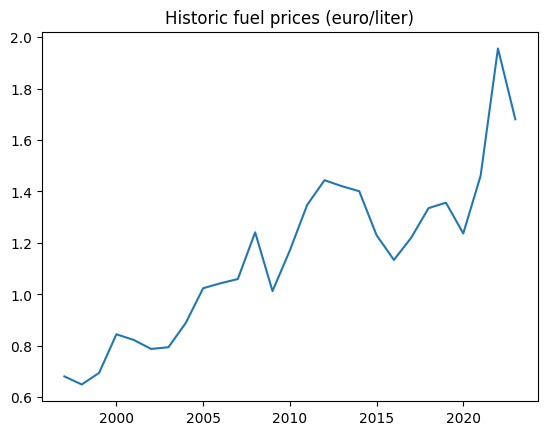

Perioden
1997    0.6812
1998    0.6499
1999    0.6949
2000    0.8450
2001    0.8230
Name: Diesel, dtype: float64


In [205]:
fuel_prices = old_fuel[(old_fuel["Perioden"] < 2006) & (old_fuel["Perioden"]>= 1997)]

#merging the two different dataframes.
for i in range(len(fuel_yearly)):
    fuel_prices = pd.concat([fuel_prices,\
        pd.DataFrame([[fuel_yearly.iloc[i].name, fuel_yearly.iloc[i]["Diesel"]]], columns = ["Perioden", "Diesel"])])
fuel_prices.set_index(fuel_prices["Perioden"], inplace = True)

plt.plot(fuel_prices["Perioden"], fuel_prices["Diesel"])
plt.title("Historic fuel prices (euro/liter)")
plt.show()
print(fuel_prices["Diesel"].head())

### 2.2 Ratio of truck to rail transport

For the two types of transport, we only take into consideration the trips that start or end in the Netherlands. Since we only look at Dutch fuel prices, it seems logical to consider routes where road vehicles would refuel in the Netherlands. We assume that routes of rail/road transport that pass through the Netherlands cannot easily be compared, and that road traffic chooses to refuel outside of the Netherlands.

          Perioden  Transport
Perioden                     
1990          1990       3056
1991          1991       3029
1992          1992       2751
1993          1993       2670
1994          1994       2806


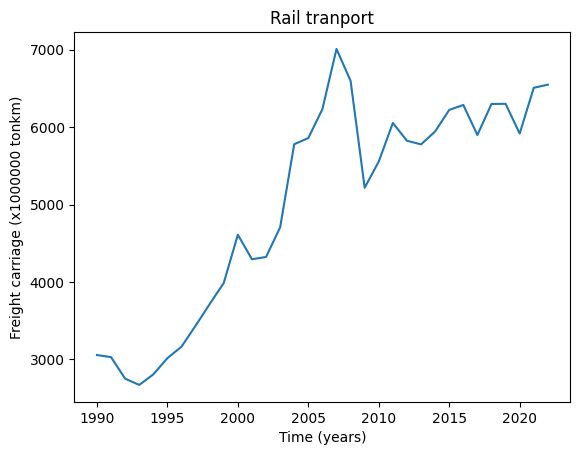

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

# Load file with rail data
rail = pd.read_csv("data/rail.csv", sep=";")

# Rename some of the columns as their name is unconveniently long
rail.rename(columns={
    "Ladingtonkilometer/Binnenlands goederenvervoer (mln tonkm)": "Binnenlands vervoer (mln tonkm)",
    "Ladingtonkilometer/Internationaal goederenvervoer/Aan- en afvoer/Totaal aan- en afvoer (mln tonkm)": "Aan- en afvoer internationaal (mln tonkm)"
}, inplace=True)

# Delete asterisks from the dataset, and convert all values to integer.
rail = rail.map(lambda x: int(str(x).replace("*", "")))

#Add up international and national transport (origin or destination in the Netherlands)
rail["Transport"] = rail["Aan- en afvoer internationaal (mln tonkm)"] + rail["Binnenlands vervoer (mln tonkm)"]
rail = rail[["Perioden", "Transport"]]

# Input the data to be represented in the graph 
dates = rail['Perioden']
values = rail['Transport']
rail.set_index(rail["Perioden"], inplace = True)

# Provide a title and axis labels
plt.title('Rail tranport')
plt.xlabel('Time (years)')
plt.ylabel('Freight carriage (x1000000 tonkm)')

print(rail.head())

# Show the graph and its characteristics
plt.plot(dates, values)
plt.show()

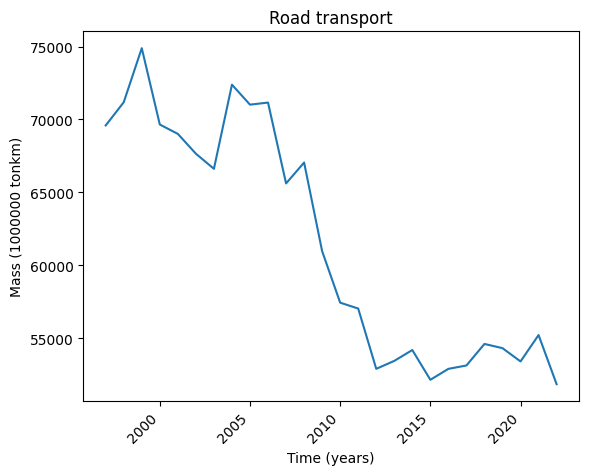

          Perioden  Ladingtonkilometers (x mln)
Perioden                                       
1997          1997                        69589
1998          1998                        71180
1999          1999                        74885
2000          2000                        69653
2001          2001                        69011


In [207]:
import pandas as pd
import matplotlib.pyplot as plt

road = pd.read_csv("data/road.csv", sep=";")
road = road.replace(',','.', regex = True)

# Delete asterisks from the dataset
road["Perioden"] = road["Perioden"].map(lambda x : int(x.replace("*", "")))

# Select data that describes commercial transport & origin or destination in the Netherlands.
transport = road[(road["Beroeps- en eigen vervoer"]=="Beroepsvervoer") & (road["Vervoerstromen"] == "Binnenlands en bilateraal vervoer")]

# Provide a title and axis labels
plt.title('Road transport')
plt.xlabel('Time (years)')
plt.ylabel('Mass (1000000 tonkm)')

road = transport[["Perioden", "Ladingtonkilometers (x mln)"]]
road.set_index(road["Perioden"], inplace = True)
# Input the data to be represented in the graph 
plt.plot(transport["Perioden"], transport["Ladingtonkilometers (x mln)"])
plt.xticks(rotation=45, ha="right")
plt.show()
print(road.head())

It becomes apparent from the graphs on road and rail transport that road transport has decreased by roughly 20 percent over the last two decades while rail transport has increased by about 15 percent over the same time period. 
	The amount of load for both transport modes seems to be very vulnerable to external factors and therefore changes a lot from year to year. The exact ratio therefore varies a lot from year to year but the ratio of rail to road transport has overall increased.

We will now put all data together in a single dataframe which we will use to answer the last two sub-questions.

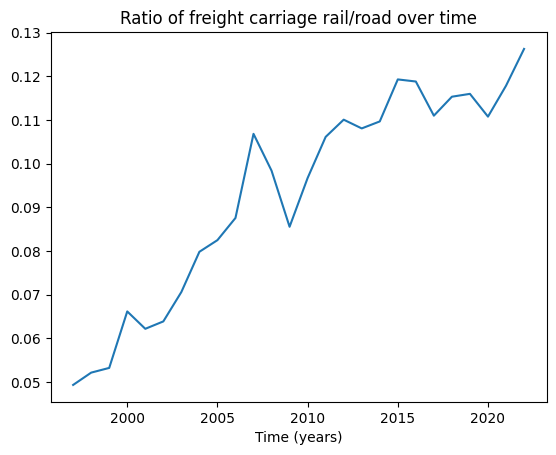

In [208]:
all_data = pd.DataFrame()
all_data["Year"] = road["Perioden"]
all_data["Road"] = road["Ladingtonkilometers (x mln)"]
all_data["Rail"] = rail["Transport"]
all_data["Diesel"] = fuel_prices["Diesel"]

#Calculate the ratio of rail transport to road transport.
all_data["Ratio"] = all_data["Rail"] / all_data["Road"]

#plot the sought after data.
plt.plot(all_data["Year"], all_data["Ratio"])
plt.title("Ratio of freight carriage rail/road over time")
plt.xlabel("Time (years)")
plt.show()

## 3 Is there a correlation?

With the found information about the popular transport mode ratio, we will make a scatter plot, and let numpy perform linear regression, using the least squares method.

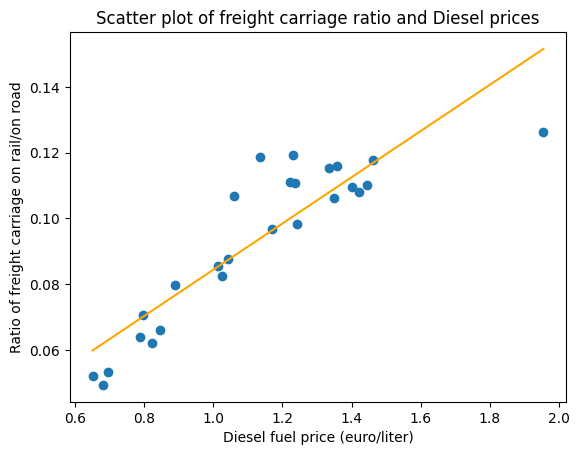

In [209]:
x = all_data["Diesel"]
y = all_data["Ratio"]

#numpy performs linear regression, and returns values for a and b.
#these represent the best linear fit, as follows: y = ax + b
a, b = np.polyfit(x, y, deg=1)

#fill in the linear fit found by numpy
xs = np.linspace(min(x), max(x), 5)
plt.plot(xs, a*xs+b, color = 'orange')

plt.scatter(x,y)
plt.title("Scatter plot of freight carriage ratio and Diesel prices")
plt.xlabel("Diesel fuel price (euro/liter)")
plt.ylabel("Ratio of freight carriage on rail/on road")
plt.show()

A quick calculation shows that there is a noticable correlation between fuel prices and freight transport mode popularity. However, we cannot immediately conclude that this correlation also implies causation. The reason for this is that all of the types of data we have looked at, have gone in roughly the same direction: fuel prices and train transport have been mostly increasing, while road transport has been mostly decreasing. There may be external factors that are the cause for these phenomena. It would be interesting to see what will happen if one of these trends goes in another direction.

## 4 Conclusion

Fuel prices have nearly doubled on the last two decades, increasing the variable costs of transport of goods by a large margin. This research looked into the correlation between the this increase in fuel prices and the change of freight transport with various tranport modes.

Rail transport is generally speaking more fuel efficient than road transport, through lower friction and higher volume of goods. After most rail transport, however, there is still a need for a road vehicle to bring cargo to the desired destination. There are many more factors that influence the demand and supply for goods.

As we have seen, there seems to be a strong correlation between the popular mode of transport at a certain moment, and the fuel price. It is still not clear if one causes the other, for that it feels like we need different types of data, for example, one of the trends changing direction, and seeing how the other datasets behave.

# 5 Discussion

It would be interesting to see how the transport modes and fuel prices interact on a quarterly, monthly, or even daily basis. This is outside of the scope of this report, for which the data was not too easy to get by.
Furthermore, it would make sense to include other types of transport, such as cargo ships and planes.